In [229]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as progress
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [2]:
data_dir = "/Users/ur001/Documents/Datasets/Hackaton-whale"
random_state = 777

%pylab inline
%config InlineBackend.figure_format = 'retina'

# отключаем ворнинги
import warnings
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


In [90]:
# Загрузка csv файла с тренировочными данными
def read_train_data():
    train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    print("total:", train_data.shape[0])
    return train_data

def load_img(file_name, subdir='train'):
    return plt.imread(os.path.join(data_dir, subdir, file_name))
    
def show_img(img, size=None):
    if size is not None:
        img = np.reshape(img, size)
    plt.imshow(img)
    plt.show()

In [59]:
train_data = read_train_data()
train_data.head()

total: 9850


Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3

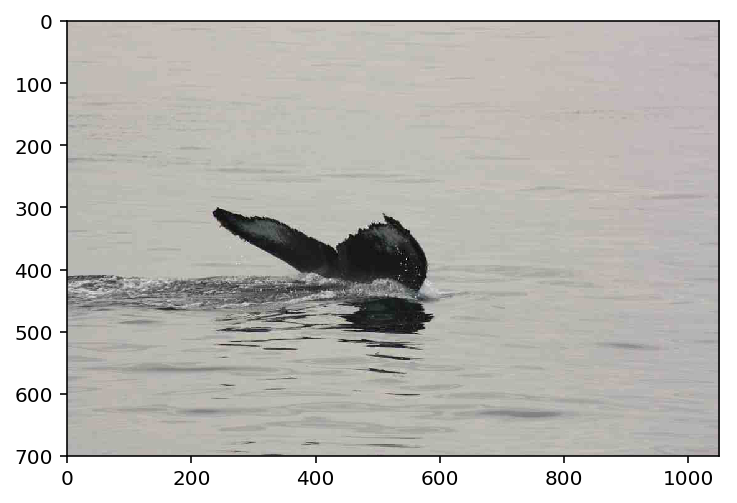

In [60]:
show_img(load_img('000466c4.jpg'))

In [98]:
# Преобразуем к 256x256 ч/б
def process_img(img):
    pil_img = Image.fromarray(img).convert('L').resize((256, 256), Image.NEAREST)
    return np.array(pil_img).flatten()

# Загрузка и обработка тренировочных картинок 
def prepare_train_data():
    X = []
    y = []

    for n, row in progress(train_data.iterrows()):
        img = load_img(row.Image)
        img = process_img(img)
        X.append(img)
        y.append(row.Id)
    return np.vstack(X), y

In [ ]:
X_train, y_train = prepare_train_data()

In [103]:
X_train.shape

(9850, 65536)

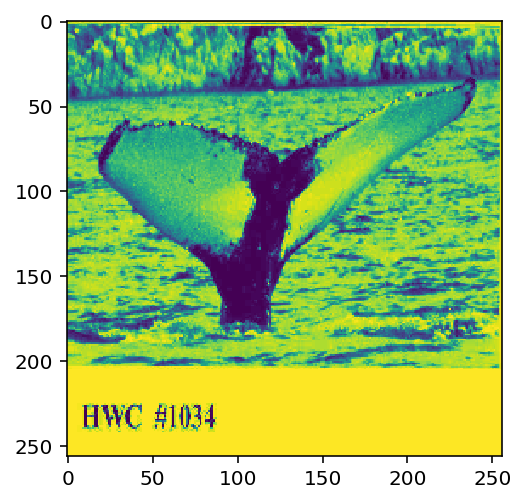

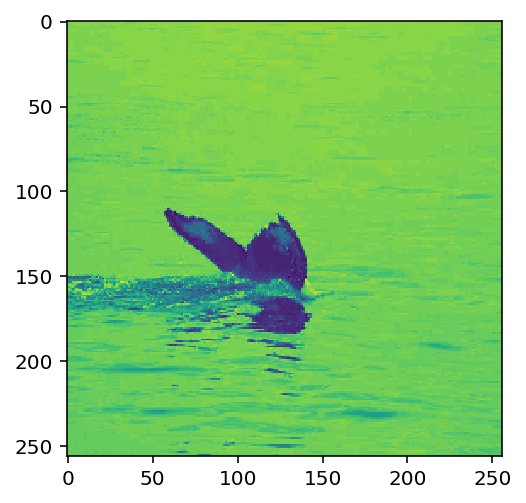

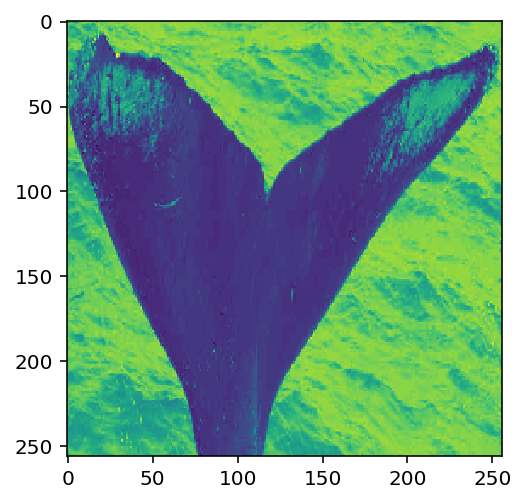

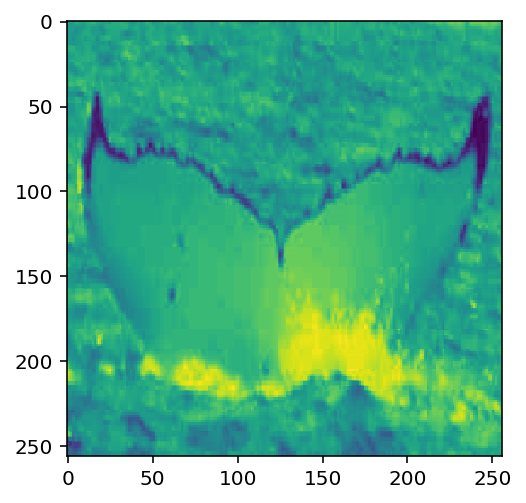

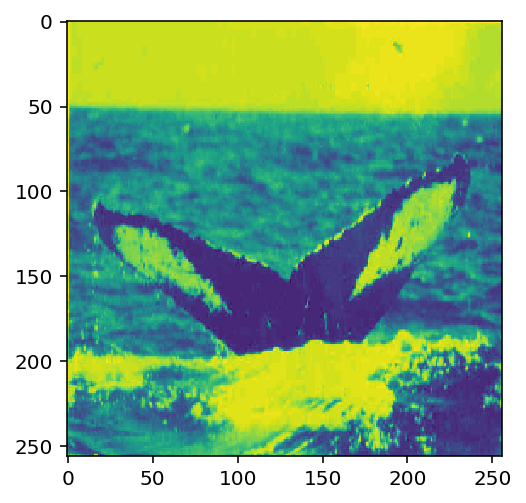

In [101]:
for img in X_train[:5]:
    show_img(img, (256, 256))

In [156]:
# Загружаем тестовые картинки
import glob

def load_test_images():
    return list(zip(*(
        (process_img(plt.imread(img_path)), img_path.rsplit('/', 1)[1])
        for img_path 
        in progress(glob.glob(os.path.join(data_dir, 'test', '*.jpg')))
    )))

In [157]:
X_test_img, X_test_fnames = load_test_images()

HBox(children=(IntProgress(value=0, max=15610), HTML(value='')))

In [104]:
# Уменьшаем размерность с помошью PCA
from sklearn.decomposition import PCA

def reduce_dimension(data, n_components):
    reducer = PCA(n_components).fit(data[0])
    return list(map(reducer.transform, data))

In [173]:
%%time
X_train_pca, X_test_pca = reduce_dimension([X_train, X_test_img], n_components=256)

CPU times: user 8min 32s, sys: 22.2 s, total: 8min 54s
Wall time: 1min 55s


In [218]:
# Пробуем 2 ближайших соседа
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train_pca, y_train)
y_predict = model.predict_proba(X_test_pca)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [182]:
# Топ-5 самых популярных китов
from collections import Counter
most_common = list(map(itemgetter(0), Counter(y_train).most_common(5)))
most_common

['new_whale', 'w_1287fbc', 'w_98baff9', 'w_7554f44', 'w_1eafe46']

In [206]:
# Возвращает склейку из наших предсказаний и самых популярных классов
def get_predict(prediction, classes, most_common, n_common=4):
    most_common = most_common[:n_common]
    top_predict = [
        classes[n_class]
        for n_class, proba in
        sorted(enumerate(prediction), reverse=True, key=itemgetter(1))[:5]
        if classes[n_class] not in most_common
    ]
    return most_common[:n_common] + top_predict[:5 - n_common]

In [207]:
get_predict(y_predict[0], model.classes_, most_common, 4)

['new_whale', 'w_1287fbc', 'w_98baff9', 'w_7554f44', 'w_98f0e93']

In [227]:
# Сабмитим 1 самый популярный (new whales) + 4 наших предсказания
submission = pd.DataFrame([
    (file_name, ' '.join(get_predict(y_predict[n], model.classes_, most_common, 1)))
    for n, file_name in enumerate(X_test_fnames)
], columns=['Image', 'Id']).set_index('Image')

submission.to_csv('submission1.csv')

In [ ]:
# 0.37602